In [1]:
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance as dist

from io import BytesIO
from IPython.display import clear_output, Image, display
from PIL import Image as Img

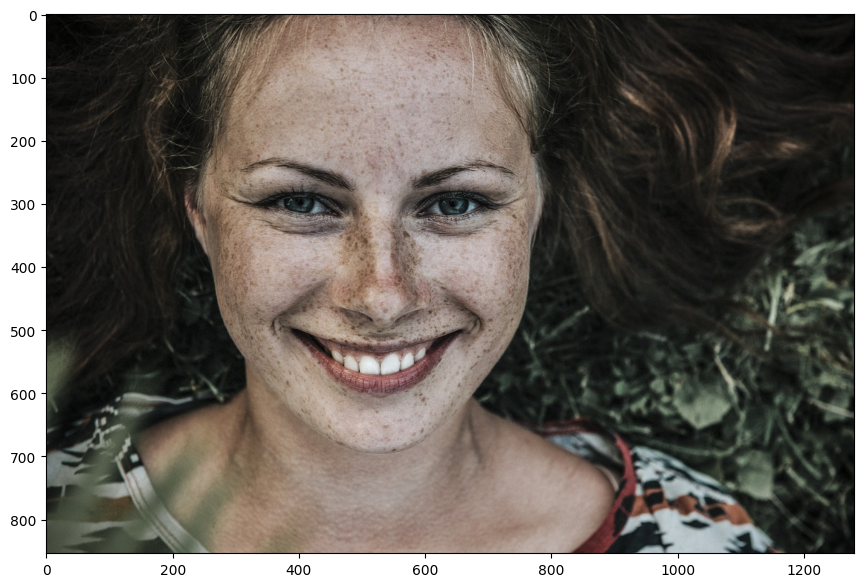

In [2]:
imagem = cv2.imread("data\images\px-woman-smilings.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14,7))
plt.imshow(imagem)

In [3]:
classificador_dlib_68_path = "data\classificadores\shape_predictor_68_face_landmarks.dat"
# download: https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat
classificador_dlib = dlib.shape_predictor(classificador_dlib_68_path)
detector_face = dlib.get_frontal_face_detector()

In [4]:
def anotar_rosto(imagem):
    retangulo = detector_face(imagem, 1)

    if len(retangulo) == 0:
        return None

    for k, d in enumerate(retangulo):
        print("Identificado rosto " + str(k))
        cv2.rectangle(imagem, (d.left(), d.top()), (d.right(), d.bottom()), (225, 255, 0), 2)
    
    return imagem

In [5]:
imagem_anotada = imagem.copy()
imagem_anotada = anotar_rosto(imagem_anotada)

Identificado rosto 0


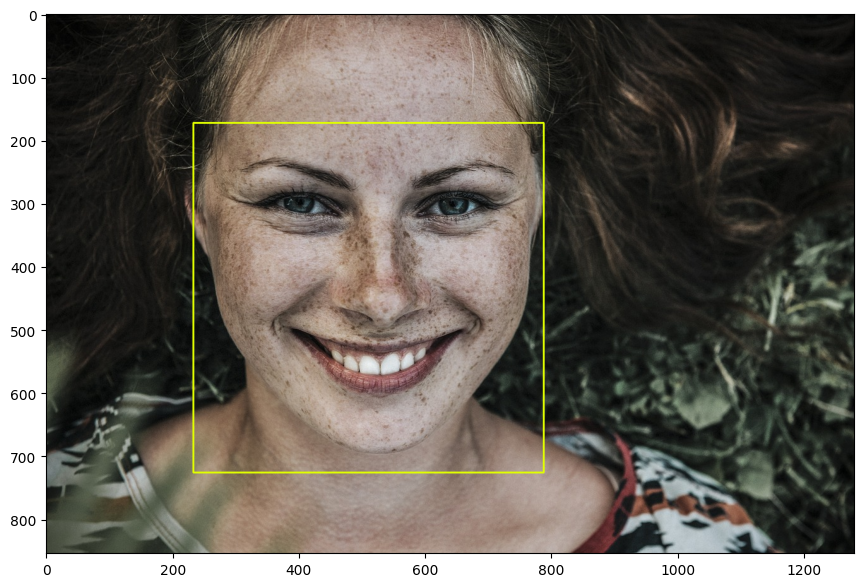

In [6]:
plt.figure(figsize=(14,7))
plt.imshow(imagem_anotada)

In [7]:
def pontos_marcos_faciais (imagem):
    retangulos = detector_face(imagem, 1)

    if len(retangulos) == 0:
        return None
    
    marcos = []

    for ret in retangulos:
        marcos.append(np.matrix([[p.x, p.y] for p in classificador_dlib(imagem, ret).parts()]))

    return marcos

In [8]:
marcos_faciais = pontos_marcos_faciais(imagem)

In [9]:
print(len(marcos_faciais), len(marcos_faciais[0]))

1 68


In [10]:
def anotar_marcos_faciais (imagem, marcos):
    for marco in marcos:
        for idx, ponto in enumerate(marco):
            centro = (ponto[0,0], ponto[0,1])
            cv2.circle(imagem, centro, 3, (255, 255, 0), -1)
            cv2.putText(imagem, str(idx), centro, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)

    return imagem

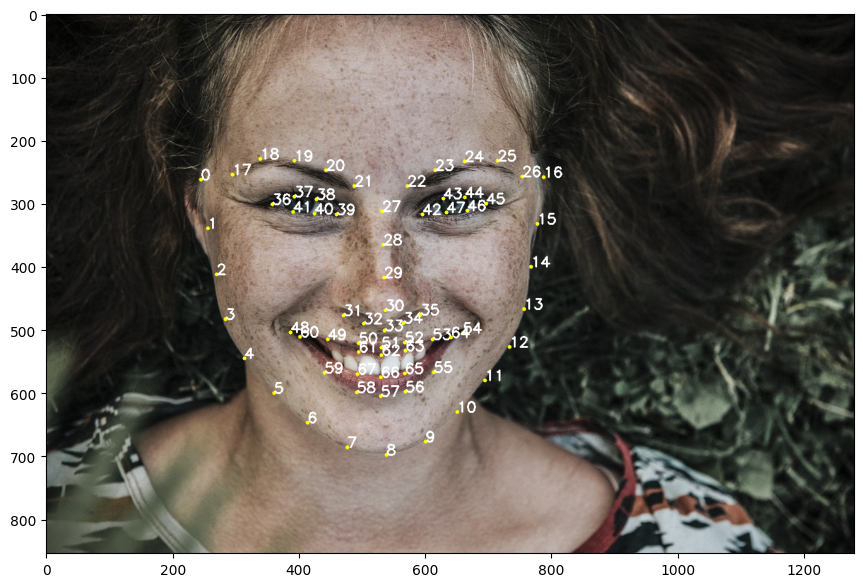

In [11]:
imagem_anotada = imagem.copy()
imagem_anotada = anotar_marcos_faciais(imagem_anotada, marcos_faciais)

plt.figure(figsize=(14,7))
plt.imshow(imagem_anotada)

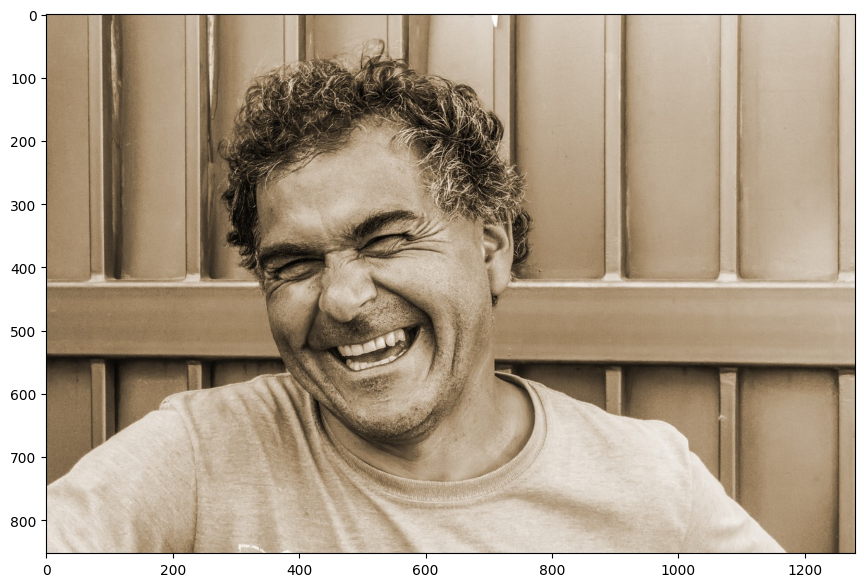

In [12]:
imagem_pessoa = cv2.imread("data\images\px-man-happy.jpg")
imagem_pessoa = cv2.cvtColor(imagem_pessoa, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14,7))
plt.imshow(imagem_pessoa)

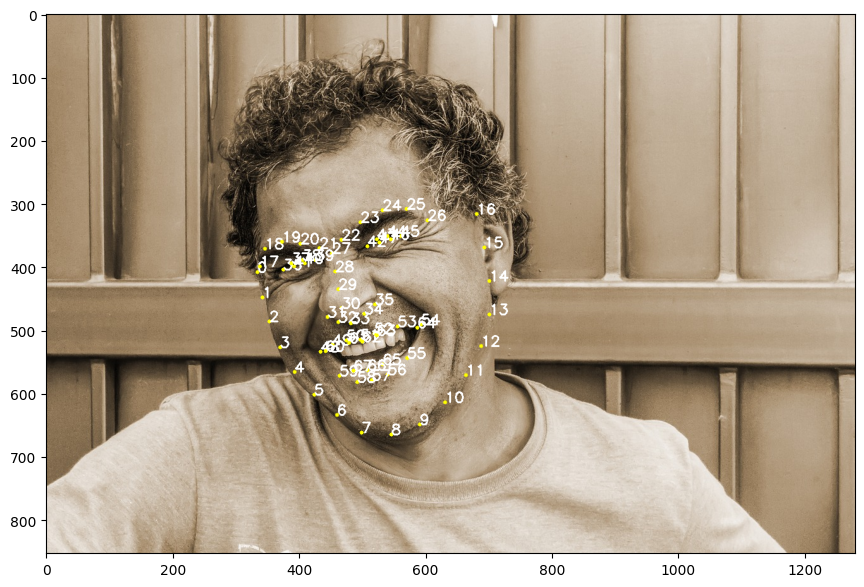

In [13]:
imagem_anotada = imagem_pessoa.copy()
marcos_faciais = pontos_marcos_faciais(imagem_anotada)
imagem_anotada = anotar_marcos_faciais(imagem_anotada, marcos_faciais)

plt.figure(figsize=(14,7))
plt.imshow(imagem_anotada)

In [14]:
FACE = list(range(17, 68))
FACE_COMPLETA = list(range(0, 68))
LABIO = list(range(48, 61))
SOMBRANCELHA_DIRETA = list(range(17, 22))
SOMBRANCELHA_ESQUERDA = list(range(22, 27))
OLHO_DIREITO = list(range(36,42))
OLHO_ESQUERDO = list(range(42,48))
NARIZ = list(range(27,35))
MANDIBULA = list(range(0,17))

In [15]:
def aspecto_razao_olhos(pontos_olhos):
    a = dist.euclidean(pontos_olhos[1].tolist()[0], pontos_olhos[5].tolist()[0])
    b = dist.euclidean(pontos_olhos[2].tolist()[0], pontos_olhos[4].tolist()[0])
    c = dist.euclidean(pontos_olhos[0].tolist()[0], pontos_olhos[3].tolist()[0])

    aspecto_razao = (a + b) / (2.0 * c)

    return aspecto_razao

In [16]:
def anotar_marcos_casca_convexa(imagem, marcos):
    retangulos = detector_face(imagem, 1)

    if len(retangulos) == 0:
        return None
    
    for idx, ret in enumerate(retangulos):
        marco = marcos[idx]

        pontos = cv2.convexHull(marco[OLHO_ESQUERDO])
        cv2.drawContours(imagem, [pontos], 0, (0,255,0), 2)

        pontos = cv2.convexHull(marco[OLHO_DIREITO])
        cv2.drawContours(imagem, [pontos], 0, (0,255,0), 2)

    return imagem

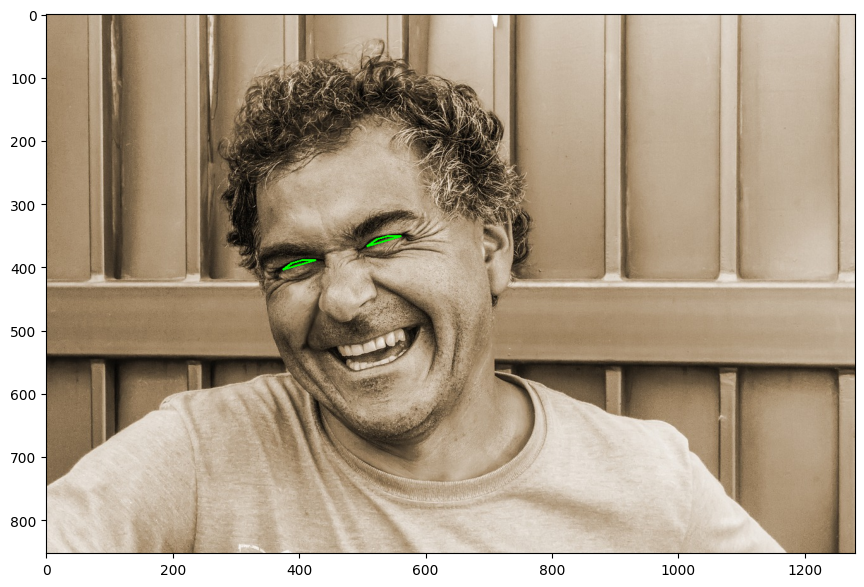

In [17]:
imagem_anotada = imagem_pessoa.copy()
imagem_anotada = anotar_marcos_casca_convexa(imagem_anotada, marcos_faciais)

plt.figure(figsize=(14,7))
plt.imshow(imagem_anotada)

In [18]:
valor_olho_esquerdo = aspecto_razao_olhos(marcos_faciais[0][OLHO_ESQUERDO])
valor_olho_direito = aspecto_razao_olhos(marcos_faciais[0][OLHO_DIREITO])
print(valor_olho_esquerdo, valor_olho_direito)

0.12169073046467273 0.12044973520917499


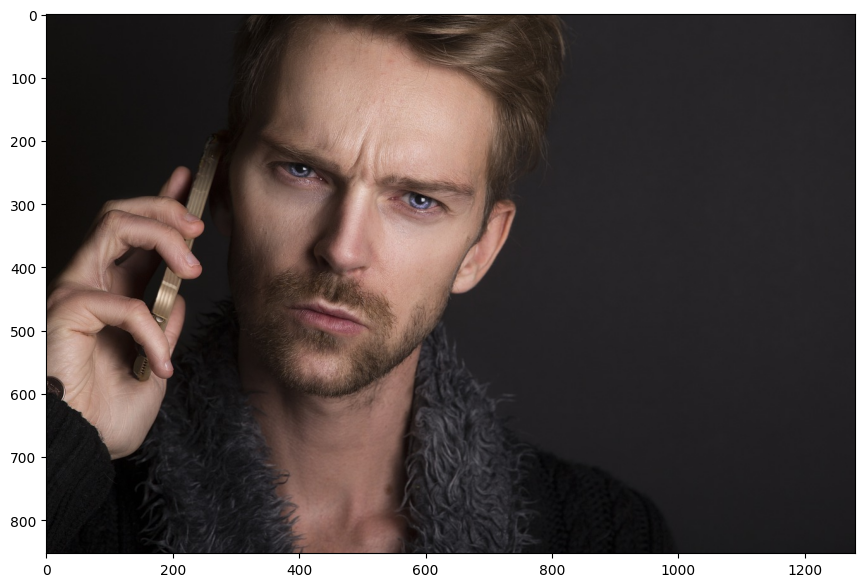

In [19]:
imagem_pessoa_seria = cv2.imread("data\images\px-man-serious.jpg")
imagem_pessoa_seria = cv2.cvtColor(imagem_pessoa_seria, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14,7))
plt.imshow(imagem_pessoa_seria)

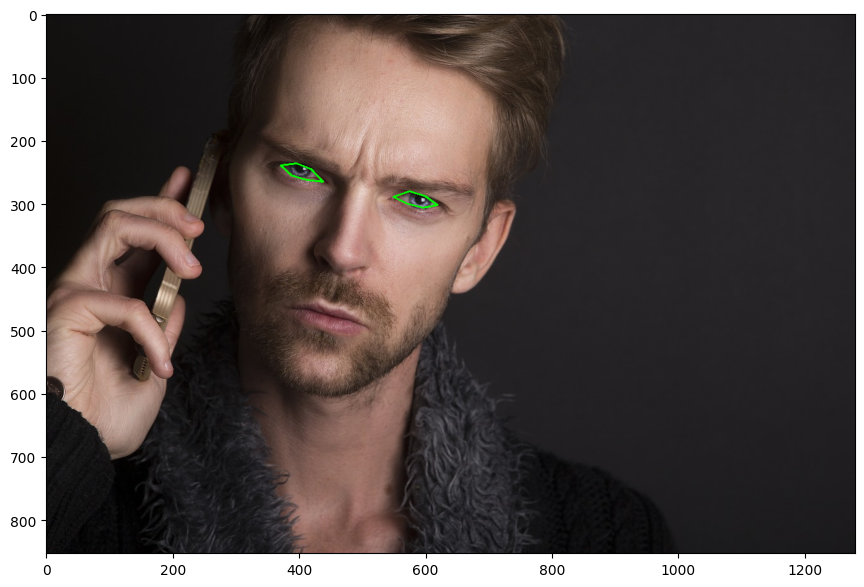

In [20]:
marcos_faciais = pontos_marcos_faciais(imagem_pessoa_seria)
imagem_anotada = imagem_pessoa_seria.copy()
imagem_anotada = anotar_marcos_casca_convexa(imagem_anotada, marcos_faciais)

plt.figure(figsize=(14,7))
plt.imshow(imagem_anotada)

In [21]:
valor_olho_esquerdo = aspecto_razao_olhos(marcos_faciais[0][OLHO_ESQUERDO])
valor_olho_direito = aspecto_razao_olhos(marcos_faciais[0][OLHO_DIREITO])
print(valor_olho_esquerdo, valor_olho_direito)

0.2715204726310253 0.27133313866169434


In [22]:
def padronizar_imagem(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (500, 400))
    return frame

In [23]:
def exibir_video(frame):
    img = Img.fromarray(frame, "RGB")
    buffer = BytesIO()
    img.save(buffer, format="JPEG")
    display(Image(data=buffer.getvalue()))
    clear_output(wait=True)

In [24]:
video = cv2.VideoCapture("data/videos/expressoes.mov")

try:
    while(True):
        captura_ok, frame = video.read()
        if captura_ok:
            frame = padronizar_imagem(frame)
            exibir_video(frame)

except:
    video.release()
    print("Interrompido")

Interrompido


In [25]:
def aspecto_razao_boca(pontos_boca):
    a = dist.euclidean(pontos_boca[3].tolist()[0], pontos_boca[9].tolist()[0])
    b = dist.euclidean(pontos_boca[2].tolist()[0], pontos_boca[10].tolist()[0])
    c = dist.euclidean(pontos_boca[4].tolist()[0], pontos_boca[8].tolist()[0])
    d = dist.euclidean(pontos_boca[0].tolist()[0], pontos_boca[6].tolist()[0])
    aspecto_razao = (a + b + c)/(3.0 * d)
    return aspecto_razao

In [26]:
def anotar_marcos_casca_convexa_boca (imagem, marcos):
    retangulos = detector_face(imagem, 1)

    if len(retangulos) == 0:
        return None
    
    for idx, ret in enumerate(retangulos):
        marco = marcos[idx]

        pontos = cv2.convexHull(marco[LABIO])
        cv2.drawContours(imagem, [pontos], 0, (0,255,0), 2)

    return imagem

In [27]:
try:
    ar_max = 0
    video = cv2.VideoCapture("data/videos/bocejo.mov")
    while(True):
        captura_ok, frame = video.read()
        if captura_ok:
            frame = padronizar_imagem(frame)
            marcos_faciais = pontos_marcos_faciais(frame)

            if marcos_faciais is not None:
                ar_boca = aspecto_razao_boca(marcos_faciais[0][LABIO])
                ar_boca = round(ar_boca, 3)

                if ar_boca > ar_max:
                    ar_max = ar_boca

                info = "boca: " + str(ar_boca) + " maximo: " + str(ar_max)

                frame = anotar_marcos_casca_convexa_boca(frame, marcos_faciais)

                cv2.putText(frame, info, (20,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 2)

            exibir_video(frame)

except:
    video.release()
    print("Interrompido")

Interrompido


In [28]:
try:
    min_olho_esq = 1
    min_olho_dir = 1
    # video = cv2.VideoCapture("data/videos/olhos-fechados.mov")
    video = cv2.VideoCapture(0)
    while(True):
        captura_ok, frame = video.read()
        if captura_ok:
            frame = padronizar_imagem(frame)
            marcos_faciais = pontos_marcos_faciais(frame)

            if marcos_faciais is not None:
                ar_olho_esq = aspecto_razao_olhos(marcos_faciais[0][OLHO_ESQUERDO])
                ar_olho_dir = aspecto_razao_olhos(marcos_faciais[0][OLHO_DIREITO])

                ar_olho_esq = round(ar_olho_esq, 3)
                ar_olho_dir = round(ar_olho_dir, 3)

                if ar_olho_esq < min_olho_esq:
                    min_olho_esq = ar_olho_esq

                if ar_olho_dir < min_olho_dir:
                    min_olho_dir = ar_olho_dir

                info_oe = "olho esquerdo: " + str(ar_olho_esq) + " minimo: " + str(min_olho_esq)
                info_od = "olho direito: " + str(ar_olho_dir) + " minimo: " + str(min_olho_dir)

                frame = anotar_marcos_casca_convexa(frame, marcos_faciais)
                
                cv2.putText(frame, info_oe, (20,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 2)
                cv2.putText(frame, info_od, (20,80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 2)

        exibir_video(frame)

except:
    video.release()
    print("Interrompido")

Interrompido
